In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import csv
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D #images are two dimensional. Videos are three dimension.
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [3]:
from keras.optimizers import Adam
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
from auto_label import auto_label, PRECISION_SOLO

In [5]:
def auto_label_last_201(seg_model, seg_nd, cluster_num, mode, threshold=0.5):
    # cluster_num: the total number of clusters
    assert mode in [1,2,3,4], "Invalid mode: mode should be integer in [1,2,3,4]."
    if mode == 1:
        assert threshold == 0.5, "Mode 1 requires threshold = 0.5."

    csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, cluster_num))
    #df = pd.read_csv(csv_file, usecols=['slice', 'current_cluster','pore_micro_precision', 'pore_micro_f1', 'gypsum_micro_precision', 'gypsum_micro_f1', 'celestite_micro_precision', 'celestite_micro_f1', 'bassanite_micro_precision', 'bassanite_micro_f1'])
    df = pd.read_csv(csv_file, usecols=['slice', 'current_cluster','pore_precision', 'pore_f1', 'gypsum_precision', 'gypsum_f1', 'celestite_precision', 'celestite_f1', 'bassanite_precision', 'bassanite_f1'])
    df =  df.loc[df['slice'] >= 600]  # only use training set

    label = [0]*cluster_num

    for i in range(cluster_num):
        one_cluster = df.loc[df['current_cluster'] == i]
        stats = one_cluster.mean()
        precisions = [stats[2], stats[4], stats[6], stats[8]]
        fscores = [stats[3], stats[5], stats[7], stats[9]]
        p_max = max(precisions)
        p_idx = np.argmax(precisions)
        f_idx = np.argmax(fscores)
        if mode in [1,2]:
            if p_max <= threshold:
                idx = f_idx
            else:
                idx = p_idx
        elif mode == 3:
            idx = f_idx
        else:
            idx = p_idx
            
        class_num = idx + 1
        label[i] = class_num

    return label

# Data Precrocessing

In [6]:
def get_cluster_num_str(c):
    c = str(c).zfill(3)
    return c

In [7]:
# Set the target segmentation results 
res_folder = 'new_large_clusters_rec'
seg_model = 'k-means'   # choose between 'gmm' and 'k-means'
seg_nd = '3d'   # choose between '3d' and '4d'
cluster_num = 16  # choose between 16, 32, 64, and 128

### Prepare Dataframe for Data Generator

In [8]:
# corresponding csv file to get slice & cluster combination
csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, cluster_num))
df = pd.read_csv(csv_file, usecols = ['slice', 'current_cluster'])
df['filename'] = df['slice'].map(str) + '\VA10_0050_0' + df['slice'].map(str) + '_' + df['current_cluster'].map(get_cluster_num_str)  + '.rec.8bit.png'

# missing information of 3D info about the first 201 slices
cluster_label_one_slice = auto_label(seg_model, seg_nd, cluster_num, PRECISION_SOLO, threshold=0)
cluster_label2 = auto_label_last_201(seg_model, seg_nd, cluster_num, PRECISION_SOLO, threshold=0)
cluster_label2, cluster_label_one_slice

In [9]:
# prepare labels for data generator
cluster_label_one_slice = auto_label_last_201(seg_model, seg_nd, cluster_num, PRECISION_SOLO, threshold=0)
cluster_label = np.array(cluster_label_one_slice*401)
df['class'] = cluster_label
df['class'] = df['class'].map(str)

### Train_Val_Test Split

#### V1.0 Random, ratio: 2:1:1

In [10]:
# randomly get 200 slices from [400, 800] and them select all clusters for these slices to form a balanced training set
slice_list = np.array(range(400, 801)) # [400,800] inclusive, 401 in total
train_slice, other_set = train_test_split(slice_list, test_size=0.5, random_state=104)
val_slice, test_slice = train_test_split(other_set, test_size=0.5, random_state=104)

In [10]:
train_set = df.loc[df['slice'].isin(train_slice)]
train_set.reset_index()
val_set = df.loc[df['slice'].isin(val_slice)]
val_set.reset_index()
test_set = df.loc[df['slice'].isin(test_slice)]
test_set.reset_index()

NameError: name 'train_slice' is not defined

#### V2.0 regarding model training set: train 600-800, val 500-699, test 400-499

In [10]:
val_slice = np.array(range(500, 600))
train_set = df.loc[df['slice'] >= 600]
train_set.reset_index()
val_set = df.loc[df['slice'].isin(val_slice)]
val_set.reset_index()
test_set = df.loc[df['slice'] < 500]
test_set.reset_index()

,index,slice,current_cluster,filename,class
0,0,400,0,400\VA10_0050_0400_000.rec.8bit.png,2
1,1,400,1,400\VA10_0050_0400_001.rec.8bit.png,2
2,2,400,2,400\VA10_0050_0400_002.rec.8bit.png,2
3,3,400,3,400\VA10_0050_0400_003.rec.8bit.png,1
4,4,400,4,400\VA10_0050_0400_004.rec.8bit.png,4
...,...,...,...,...,...
1595,1595,499,11,499\VA10_0050_0499_011.rec.8bit.png,2
1596,1596,499,12,499\VA10_0050_0499_012.rec.8bit.png,3
1597,1597,499,13,499\VA10_0050_0499_013.rec.8bit.png,4
1598,1598,499,14,499\VA10_0050_0499_014.rec.8bit.png,2


### Get Data Generator for Train/Val/Test

In [11]:
batch_size = 8

# Data path: used in data generator
base_folder = os.path.join(os.getcwd(), res_folder, seg_model, seg_nd, 'cluster_{}'.format(cluster_num))

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_set, directory=base_folder,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=True,
                                             class_mode='categorical',
                                             seed=7)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_set, directory=base_folder,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=True,
                                             class_mode='categorical',
                                             seed=7)


test_generator = test_datagen.flow_from_dataframe(dataframe=test_set, directory=base_folder,
                                             x_col='filename',
                                             y_col=None,
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             class_mode=None,
                                             seed=7
                                             )

Found 3216 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames.


# Model

In [12]:
vgg16_model = VGG16(include_top=False, input_shape=(700, 855, 3))
for layer in vgg16_model.layers:
    layer.trainable = False
x = Flatten()(vgg16_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700, 855, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 700, 855, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 700, 855, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 350, 427, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 350, 427, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 350, 427, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 175, 213, 128)     0     

# Training 

Skip if model already trained; Go to next session 'Load Model'

In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [14]:
#model_name = 'vgg16_201based_models\{}_{}_{}_vgg16.h5'.format(seg_model, seg_nd, cluster_num)
model_name = 'vgg_201_aligned_model\{}_{}_{}_vgg16_non_trainable_fc.h5'.format(seg_model, seg_nd, cluster_num)
earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
callbacks = [checkpoint, earlystop, reduce_lr_loss]

mlp model has to use batch size 4 to successfully run; vgg16 nontrainable/trainable without fully connection would use batch size 16; vgg16 nontrainable with fully connected has to reduce to 8.

In [15]:
start = datetime.now()
model_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=callbacks, verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50


C:\Users\s1923493\AppData\Local\Temp\ipykernel_21520\4189160232.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator=train_generator,


402/402 [==============================] - 235s 567ms/step - loss: 1.9172 - accuracy: 0.9698 - val_loss: 2.6853 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 2/50
402/402 [==============================] - 207s 516ms/step - loss: 1.3715e-09 - accuracy: 1.0000 - val_loss: 2.6851 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 3/50
402/402 [==============================] - 201s 502ms/step - loss: 5.5601e-10 - accuracy: 1.0000 - val_loss: 2.6849 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 4/50
402/402 [==============================] - 126s 314ms/step - loss: 2.2734 - accuracy: 0.9854 - val_loss: 22.9265 - val_accuracy: 0.9381 - lr: 1.0000e-04
Epoch 5/50
402/402 [==============================] - 128s 319ms/step - loss: 0.2501 - accuracy: 0.9972 - val_loss: 38.4164 - val_accuracy: 0.8494 - lr: 1.0000e-04
Epoch 6/50
402/402 [==============================] - 128s 319ms/step - loss: 0.5090 - accuracy: 0.9969 - val_loss: 22.6384 - val_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 7/50
402/402 [==

# Load Trained Model

In [ ]:
model_name = 'vgg_201_aligned_model\k-means_3d_{}_vgg16_non_trainable_fc.h5'.format(cluster_num)
model = load_model(model_name)

# Evaluation & Tests

In [16]:
test_generator.reset()
pred=model.predict(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

200/200 [==============================] - 34s 167ms/step


In [18]:
pred

array([[5.4025583e-26, 1.0000000e+00, 0.0000000e+00, 6.2136481e-22],
       [1.2198054e-04, 3.4957742e-05, 9.9982750e-01, 1.5521593e-05],
       [9.9999201e-01, 7.4633431e-06, 0.0000000e+00, 4.2896013e-07],
       ...,
       [3.0132676e-12, 1.0000000e+00, 1.1441091e-34, 4.9777465e-10],
       [1.2707151e-27, 1.0000000e+00, 0.0000000e+00, 3.8714437e-20],
       [4.8700044e-24, 6.5656660e-17, 0.0000000e+00, 1.0000000e+00]],
      dtype=float32)

In [17]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.880625
[0.988      0.85561497 1.         0.83333333] [0.82333333 1.         0.97       0.6625    ] [0.89818182 0.9221902  0.98477157 0.73816156]
macro-averaged of 4 classes:
0.9192370766488414 0.8858262883508913 0.8858262883508913
macro-averaged of 3 classes:
0.8923161021984551 0.8528445265998349 0.8528445265998349


# Plots

In [18]:
# list all data in history
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [18]:
img_folder = os.path.join('report_images', 'model_plots', 'vgg16_aligned')

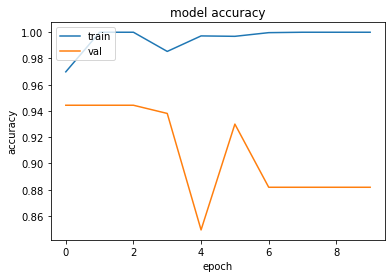

In [19]:
# summarize history for accuracy
acc_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_acc.pdf'.format(seg_model, seg_nd, cluster_num))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(acc_img)
plt.show()

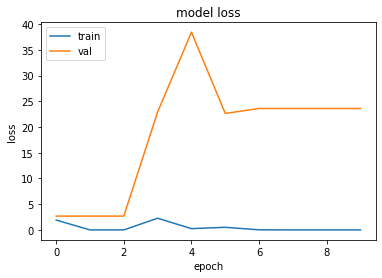

In [20]:
# summarize history for loss
loss_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_loss.pdf'.format(seg_model, seg_nd, cluster_num))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(loss_img)
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

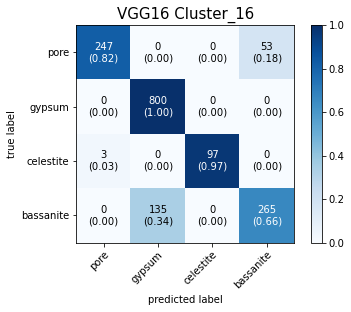

In [22]:
cm_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_cm.pdf'.format(seg_model, seg_nd, cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('VGG16 Cluster_{}'.format(cluster_num), fontsize=15)
plt.savefig(cm_img)
plt.show()


# Test on results from other cluster num

### Prepare label

In [41]:
other_cluster_num = 128

In [42]:
# corresponding csv file to get slice & cluster combination
csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, other_cluster_num))
df = pd.read_csv(csv_file, usecols = ['slice', 'current_cluster'])
df['filename'] = df['slice'].map(str) + '\VA10_0050_0' + df['slice'].map(str) + '_' + df['current_cluster'].map(get_cluster_num_str)  + '.rec.8bit.png'

In [43]:
# prepare labels for data generator
cluster_label_one_slice = auto_label_last_201(seg_model, seg_nd, other_cluster_num, PRECISION_SOLO, threshold=0)
cluster_label = np.array(cluster_label_one_slice*401)
df['class'] = cluster_label
df['class'] = df['class'].map(str)

In [44]:
test_set = df.loc[df['slice'] < 500]
test_set.reset_index()

,index,slice,current_cluster,filename,class
0,0,400,0,400\VA10_0050_0400_000.rec.8bit.png,2
1,1,400,1,400\VA10_0050_0400_001.rec.8bit.png,4
2,2,400,2,400\VA10_0050_0400_002.rec.8bit.png,2
3,3,400,3,400\VA10_0050_0400_003.rec.8bit.png,2
4,4,400,4,400\VA10_0050_0400_004.rec.8bit.png,4
...,...,...,...,...,...
12795,12795,499,123,499\VA10_0050_0499_123.rec.8bit.png,2
12796,12796,499,124,499\VA10_0050_0499_124.rec.8bit.png,2
12797,12797,499,125,499\VA10_0050_0499_125.rec.8bit.png,1
12798,12798,499,126,499\VA10_0050_0499_126.rec.8bit.png,4


### Prepare data

In [45]:
batch_size = 8

# Data path: used in data generator
base_folder = os.path.join(os.getcwd(), res_folder, seg_model, seg_nd, 'cluster_{}'.format(other_cluster_num))

other_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
other_test_generator = other_test_datagen.flow_from_dataframe(dataframe=test_set, directory=base_folder,
                                             x_col='filename',
                                             y_col=None,
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             class_mode=None,
                                             seed=7
                                             )

Found 12800 validated image filenames.


### Load model and test

In [ ]:
model_name = '{}_{}_{}_vgg16.h5'.format(seg_model, seg_nd, cluster_num)
model = load_model(model_name)

In [46]:
STEP_SIZE_TEST=other_test_generator.n//other_test_generator.batch_size

In [47]:
other_test_generator.reset()
pred=model.predict(other_test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

1600/1600 [==============================] - 277s 173ms/step


## Stats for apply on cluster 128

In [48]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.6675
[0.38395002 0.93261408 1.         0.95892351] [0.99875    0.86442623 0.985      0.16512195] [0.55466852 0.89722648 0.99244332 0.28173117]
macro-averaged of 4 classes:
0.8188719038258152 0.6815173720694072 0.6815173720694072
macro-averaged of 3 classes:
0.7584958717677536 0.5778753877802004 0.5778753877802004


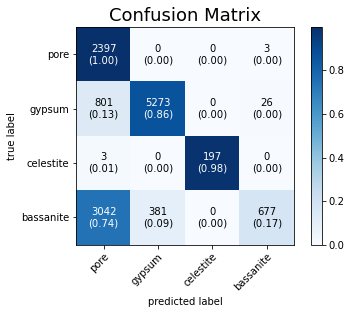

In [49]:
cm_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 64

In [39]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.83
[0.61781377 0.98522167 1.         0.9120603 ] [0.95375    0.89655172 0.97       0.605     ] [0.74987715 0.93879762 0.98477157 0.72745491]
macro-averaged of 4 classes:
0.8787739353916428 0.8502253125498018 0.8502253125498018
macro-averaged of 3 classes:
0.8383652471888571 0.8053765588650487 0.8053765588650487


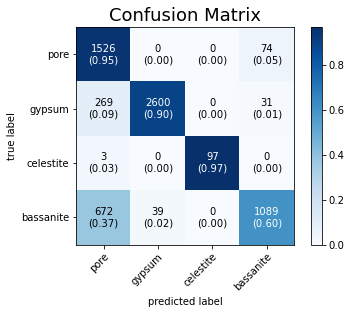

In [40]:
cm_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 32

In [30]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.8546875
[0.81944444 0.92649784 1.         0.7257485 ] [0.75857143 0.9375     0.98       0.7575    ] [0.78783383 0.93196645 0.98989899 0.7412844 ]
macro-averaged of 4 classes:
0.8679226964025418 0.8627459176674295 0.8627459176674295
macro-averaged of 3 classes:
0.8238969285367225 0.8203615602569094 0.8203615602569094


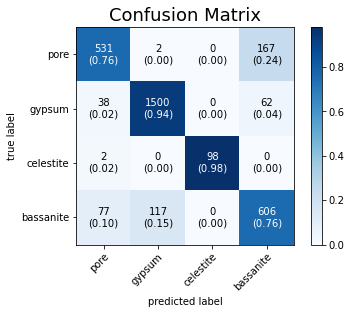

In [31]:
cm_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 16

In [48]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.773125
[1.         0.8654321  1.         0.53818182] [0.46666667 0.87625    1.         0.74      ] [0.63636364 0.87080745 1.         0.62315789]
macro-averaged of 4 classes:
0.8509034792368125 0.7825822461291568 0.7825822461291568
macro-averaged of 3 classes:
0.8012046389824167 0.7101096615055424 0.7101096615055424


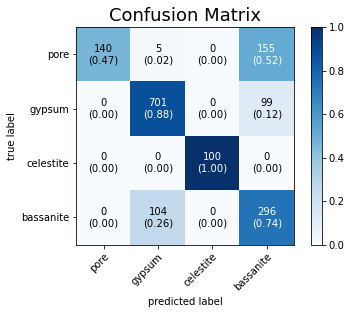

In [49]:
cm_img = os.path.join(img_folder, '{}_{}_{}_vgg_full_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()